In [237]:
from tensorflow import keras
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sn
import os
import cv2
import imghdr

In [238]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [239]:
tf.config.list_physical_devices('GPU')

[]

1.REMOVE USELESS FILE TYPES 

In [240]:
import os
import cv2
import imghdr

from pathlib import Path

# data_dir = Path(r"C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\ImageClassification")
data_dir = Path(r"C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\PYTHON_KURSY\\python\\Jupyter_nauka\\Projekty\\6_DL_Image_HAppy_Sad\\data")
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    class_dir = data_dir / image_class
    if class_dir.is_dir():  # Upewnij się, że ścieżka jest katalogiem
        for image in os.listdir(class_dir):
            image_path = class_dir / image
            try:
                img = cv2.imread(str(image_path))  # Konwertuj na str, ponieważ pathlib.Path nie jest obsługiwany bezpośrednio przez cv2.imread()
                tip = imghdr.what(str(image_path))  # Konwertuj na str
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(str(image_path))
            except Exception as e:
                print('Issue with image {}'.format(image_path))
                # os.remove(str(image_path))  # Jeśli chcesz usuwać pliki, odkomentuj tę linię


2.LOAD DATA

In [241]:
data = tf.keras.utils.image_dataset_from_directory('data')#ładujemy dane i ustawiamy je w klasach zaleznych od folderow

Found 136 files belonging to 2 classes.


In [242]:
data_iterator =data.as_numpy_iterator()

In [243]:
batch = data_iterator.next()

In [244]:
batch[1]#0 i 1 reprezentuja jedna z klas happy czy sad

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1])

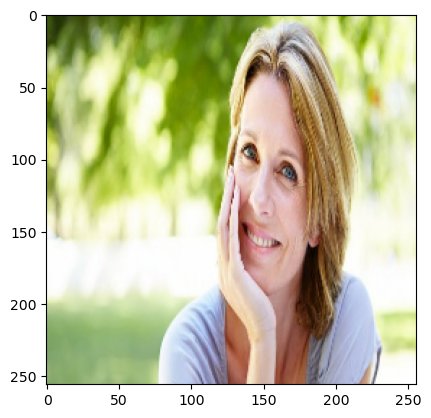

In [245]:

img  = batch[0][5]# z tego wiem ze jedynki oznaczaja klase sad: 1==SAD
plt.imshow(img.astype(int))

Wgranie zdjecia

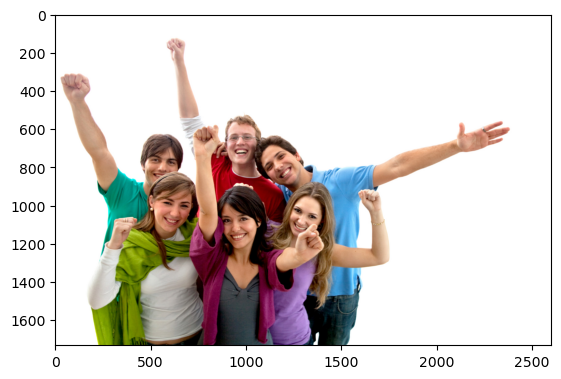

In [246]:
img = cv2.imread("C:\\Users\\AdrianKurzac(261404)\\Documents\\GitHub\\PYTHON_KURSY\\python\\Jupyter_nauka\\Projekty\\6_DL_Image_HAppy_Sad\\data\\happy\\8cxKy5g9i.jpg")
img.shape
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
plt.imshow(img)

3.Preprocess DATA

Scale data

In [247]:
data = data.map(lambda x,y: (x/255,y))
scaled_iterator = data.as_numpy_iterator()


In [248]:
batch = scaled_iterator.next()

In [249]:
batch[0].min()

0.0

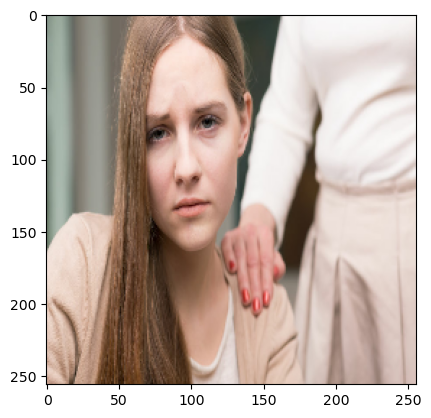

In [250]:
img  = batch[0][5]# z tego wiem ze jedynki oznaczaja klase sad: 1==SAD

plt.imshow(img)


4.SPLIT DATA FOR TRAINING

In [251]:
a = len(data)
a

5

In [252]:
train_size = int(a*0.7)
train_size

3

In [253]:
valid_size = int(a*0.2)
valid_size

1

In [254]:
test_size = int(a*0.1)+1
test_size

1

In [255]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size+valid_size).take(test_size)

In [256]:
len(test)

1

5.BUILD DEEP LEARNING MODEL

In [257]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

6.TRAIN MODEL

7.PLOT PERFORMANCE

8.EVALUETE

9. EVALUETE